# Data Part

In [1]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,338 kB/s)
Selecting previously unselected

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import seaborn as sns

In [3]:
parish_data=gpd.read_file('/content/parks_parishes.geojson')
parish_poly=parish_data[['Green_Zone_name','Dicofre','geometry']]
green_areas = pd.read_csv('https://raw.githubusercontent.com/SowmyaMadala/WDL-Stage4/main/Data/Attracting%20Population/WDL_Green_Areas_Dataset_V1.txt' ,sep ="|", encoding ="latin-1").rename(columns = {'Number of Museums in influence area' : 'no_of_museums',
                                                                                                                                  'Number of parking lots in influence area' : 'no_of_parking_lots',
                                                                                                                                   'Number of tourist attractions in influence area': 'no_of_tourist_attractions', 
                                                                                                                                   'Green Zones Daily Average Demand':'gz_daily_avg_demand',
                                                                                                                                    'Daily average of people in influence area': 'daily_avg_people',
                                                                                                                                    'Number of buildings in influence area' : 'no_of_buildings',
                                                                                                                                    'Number of families in influence area': 'no_of_families',
                                                                                                                                    'Number of people resident in influence area' : 'no_of_people_resident'})
resident  = green_areas.loc[green_areas['Resident']==1]
resident = resident.rename(columns= {'daily_avg_people': 'daily_avg_people_resident'})
non_resident  = green_areas.loc[green_areas['Resident']==0]
non_resident = non_resident.rename(columns= {'daily_avg_people': 'daily_avg_people_non_resident'})
combined_data = pd.merge(resident, non_resident[['Green_Zone_name', 'daily_avg_people_non_resident']], how = "inner", on = ['Green_Zone_name']).drop(columns=['Resident'])
total_avg_people=combined_data['daily_avg_people_non_resident']+combined_data['daily_avg_people_resident']
combined_data['total_daily_avg_people']=total_avg_people
gz_daily_demand_resident=(combined_data['daily_avg_people_resident']/combined_data['total_daily_avg_people'])*combined_data['gz_daily_avg_demand']
combined_data['gz_daily_avg_demand_res']=gz_daily_demand_resident
combined_data=pd.merge(left=combined_data,right=parish_poly,how='inner',on='Green_Zone_name')
socio_data=pd.read_csv('https://raw.githubusercontent.com/SowmyaMadala/WDL-Stage4/main/merged_2020.csv')

In [4]:
combined_data['Dicofre'] = combined_data.Dicofre.astype(int)
merged=pd.merge(left=combined_data,right=socio_data,how='inner',left_on='Dicofre',right_on='ParishCode')
merged.head(2)

,Green_Zone_name,no_of_museums,no_of_parking_lots,no_of_tourist_attractions,gz_daily_avg_demand,daily_avg_people_resident,no_of_buildings,no_of_families,no_of_people_resident,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y,daily_avg_people_non_resident,total_daily_avg_people,gz_daily_avg_demand_res,Dicofre,geometry,ParishCode,Parish,MF,M,F,MedianRent_per_m2,Area(Km2),Average_monthly_rental_charges
0,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,17780.803014,4783,15352,38012,0.195123,0.196017,-8.68415,41.16001,45787.629298,63568.432312,1.042953,131216,"POLYGON ((-8.68544 41.16198, -8.68570 41.16189...",131216,"União das freguesias de Aldoar, Foz do Douro e...",244,118,126,9.03,6.27,387.96
1,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,17497.825376,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674,42877.741202,60375.566578,2.973259,110658,"POLYGON ((-9.20107 38.69706, -9.19972 38.69729...",110658,Belém,173,91,82,11.21,7.12,431.90


In [6]:
#f, ax = plt.subplots(figsize=(20, 20))
corr_mat=merged.corr()
#sns.heatmap(corr_mat,annot=True)
#plt.show()

In [7]:
corr_mat['gz_daily_avg_demand_res'].sort_values(ascending=False)

gz_daily_avg_demand_res           1.000000
gz_daily_avg_demand               0.838656
perc_pop_until_19_yo              0.193711
no_of_museums                     0.191531
no_of_parking_lots                0.141607
no_of_tourist_attractions         0.117483
POINT_X                           0.088850
Average_monthly_rental_charges    0.079055
POINT_Y                           0.076456
Dicofre                           0.075378
ParishCode                        0.075378
no_of_buildings                   0.015653
MedianRent_per_m2                 0.001857
M                                -0.001206
MF                               -0.004031
F                                -0.006730
daily_avg_people_resident        -0.035889
Area(Km2)                        -0.124422
total_daily_avg_people           -0.141815
daily_avg_people_non_resident    -0.154157
no_of_people_resident            -0.160842
perc_senior_pop                  -0.165820
no_of_families                   -0.171329
Name: gz_da

It is found that among all the attributes green space demand is mostly correlated to perc_pop_until_19_yo, no_of_museums, no_of_parking_lots, no_of_tourist_attractions.
So let's try building a model that helps in predicting the green space based on these attributes

In [8]:
reg_data=merged[['no_of_tourist_attractions','perc_pop_until_19_yo','no_of_museums','no_of_parking_lots','gz_daily_avg_demand_res']]
reg_data.head(4)

,no_of_tourist_attractions,perc_pop_until_19_yo,no_of_museums,no_of_parking_lots,gz_daily_avg_demand_res
0,30,0.196017,5,28,1.042953
1,78,0.204917,93,129,2.973259
2,4,0.204917,8,23,13.722170
3,93,0.252080,107,191,201.023191


# Models

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
X=reg_data.drop(columns='gz_daily_avg_demand_res')
y=reg_data['gz_daily_avg_demand_res']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

**Standardisation:**

All features are numeric so we do not need to worry about converting categorical data with techniques such as one-hot encoding. Standardisation rescales our attributes so they have a mean of 0 and standard deviation of 1. It assumes that the distribution is Gaussian (it works better if it is), alternatively normalisation can be used to rescale between the range of 0 and 1

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

**Linear Regression**

In [12]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
mse = mean_squared_error(y_train, model1.predict(train_scaled))
mae = mean_absolute_error(y_train, model1.predict(train_scaled))
print("mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))

mse =  28624.371743932756  & mae =  89.32144986671192  & rmse =  169.18738647999962


The easier metric to understand is the mean absolute error, this means that on average our prediction was 89.3 away from the true prediction. Mean squared error, and consequently root mean squared error (RMSE), results in predictions further and further from the true value are punished more.

In [14]:
#We can calculate the same on the test data to understand how we the model is generalised.
test_mse = mean_squared_error(y_test, model1.predict(test_scaled))
test_mae = mean_absolute_error(y_test, model1.predict(test_scaled))
print("mse = ",test_mse," & mae = ",test_mae," & rmse = ", sqrt(test_mse))

mse =  27780.914191569023  & mae =  121.36934160594096  & rmse =  166.67607564245392


In [15]:
#Lets try training the model without standardizing
from sklearn.linear_model import LinearRegression
model2 = LinearRegression()
model2.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
mse = mean_squared_error(y_train, model2.predict(X_train))
mae = mean_absolute_error(y_train, model2.predict(X_train))
print("mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))

mse =  28624.37174393277  & mae =  89.32144986670971  & rmse =  169.18738647999965


In [17]:
#We can calculate the same on the test data to understand how we the model is generalised.
test_mse = mean_squared_error(y_test, model2.predict(X_test))
test_mae = mean_absolute_error(y_test, model2.predict(X_test))
print("mse = ",test_mse," & mae = ",test_mae," & rmse = ", sqrt(test_mse))

mse =  27780.914191569642  & mae =  121.36934160594531  & rmse =  166.67607564245577


**Decision Trees & Random Forests**

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
tree_model = DecisionTreeRegressor()
rf_model = RandomForestRegressor()
tree_model.fit(train_scaled, y_train)
rf_model.fit(train_scaled, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [19]:
tree_mse = mean_squared_error(y_train, tree_model.predict(train_scaled))
tree_mae = mean_absolute_error(y_train, tree_model.predict(train_scaled))
rf_mse = mean_squared_error(y_train, rf_model.predict(train_scaled))
rf_mae = mean_absolute_error(y_train, rf_model.predict(train_scaled))

In [20]:
print("Decision Tree training mse = ",tree_mse," & mae = ",tree_mae," & rmse = ", sqrt(tree_mse))
print("Random Forest training mse = ",rf_mse," & mae = ",rf_mae," & rmse = ", sqrt(rf_mse))

Decision Tree training mse =  9.475344854482621  & mae =  0.6489425536802201  & rmse =  3.0782048103533692
Random Forest training mse =  5492.892774487181  & mae =  34.83818605868552  & rmse =  74.11405247648506


The easier metric to understand is the mean absolute error, this means that our predictions were perfect for the decision tree model but on average 32.39 away from the true prediction with the random forest model. Mean squared error, and consequently root mean squared error (RMSE), results in predictions further and further from the true value are punished more.

In [21]:
tree_test_mse = mean_squared_error(y_test, tree_model.predict(test_scaled))
tree_test_mae = mean_absolute_error(y_test, tree_model.predict(test_scaled))
rf_test_mse = mean_squared_error(y_test, rf_model.predict(test_scaled))
rf_test_mae = mean_absolute_error(y_test, rf_model.predict(test_scaled))

In [22]:
print("Decision Tree test mse = ",tree_test_mse," & mae = ",tree_test_mae," & rmse = ", sqrt(tree_test_mse))
print("Random Forest test mse = ",rf_test_mse," & mae = ",rf_test_mae," & rmse = ", sqrt(rf_test_mse))

Decision Tree test mse =  26424.30110527852  & mae =  64.70354817429086  & rmse =  162.55553237364308
Random Forest test mse =  36801.22084387096  & mae =  117.48785251900392  & rmse =  191.83644295042316


**K Nearest Neighbors**

K-Nearest Neighbor (KNN) makes a prediction for a new observation by searching for the most similar training observations and pooling their values.

In [23]:
from sklearn.neighbors import KNeighborsRegressor
knnmodel = KNeighborsRegressor()
knnmodel.fit(train_scaled, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [24]:
#Evaluating model on train dataset
mse = mean_squared_error(y_train, knnmodel.predict(train_scaled))
mae = mean_absolute_error(y_train, knnmodel.predict(train_scaled))
print("mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))

mse =  18004.51011991257  & mae =  59.02812122838639  & rmse =  134.1808858217614


In [25]:
#Evaluating model on test dataset
test_mse = mean_squared_error(y_test, knnmodel.predict(test_scaled))
test_mae = mean_absolute_error(y_test, knnmodel.predict(test_scaled))
print("mse = ",test_mse," & mae = ",test_mae," & rmse = ", sqrt(test_mse))

mse =  35690.13760014362  & mae =  106.92658727095515  & rmse =  188.9183357965648


**Ridge Regression**

In [26]:
from sklearn.linear_model import LinearRegression, Ridge
ridge_reg = Ridge(alpha=0)
ridge_reg.fit(train_scaled, y_train)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [27]:
#Evaluating model on train dataset
mse = mean_squared_error(y_train, ridge_reg.predict(train_scaled))
mae = mean_absolute_error(y_train, ridge_reg.predict(train_scaled))
print("mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))

mse =  28624.371743932756  & mae =  89.32144986671194  & rmse =  169.18738647999962


In [28]:
#Evaluating model on test dataset
test_mse = mean_squared_error(y_test, ridge_reg.predict(test_scaled))
test_mae = mean_absolute_error(y_test, ridge_reg.predict(test_scaled))
print("mse = ",test_mse," & mae = ",test_mae," & rmse = ", sqrt(test_mse))

mse =  27780.914191569027  & mae =  121.36934160594097  & rmse =  166.67607564245395


**Bayesian Regression**

In [29]:
from sklearn.linear_model import BayesianRidge
bayesian_model = BayesianRidge()
bayesian_model.fit(train_scaled, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [30]:
#Evaluating model on train dataset
mse = mean_squared_error(y_train, bayesian_model.predict(train_scaled))
mae = mean_absolute_error(y_train, bayesian_model.predict(train_scaled))
print("mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))

mse =  30372.330927217234  & mae =  95.95048509103077  & rmse =  174.27659317079053


In [31]:
#Evaluating model on test dataset
test_mse = mean_squared_error(y_test, bayesian_model.predict(test_scaled))
test_mae = mean_absolute_error(y_test, bayesian_model.predict(test_scaled))
print("mse = ",test_mse," & mae = ",test_mae," & rmse = ", sqrt(test_mse))

mse =  25590.61734600241  & mae =  99.56190534978082  & rmse =  159.97067651917465


**Polynomial Regression**

In [34]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)
model = LinearRegression()
model.fit(x_poly, y_train)
y_poly_pred = model.predict(x_poly_test)
rmse = np.sqrt(mean_squared_error(y_test,y_poly_pred))
r2 = r2_score(y_test,y_poly_pred)
print(rmse)
print(r2)

200.5711829202867
-0.5765065298523371


**Principal Component regression**

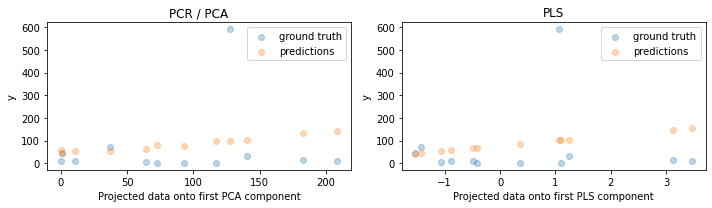

PCR r-squared -0.005
PLS r-squared -0.027
PCR r-squared with 2 components 0.036


In [36]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
pca = PCA(n_components=2).fit(X)
pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps['pca']  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=.3, label='ground truth')
axes[0].scatter(pca.transform(X_test), pcr.predict(X_test), alpha=.3,
                label='predictions')
axes[0].set(xlabel='Projected data onto first PCA component',
            ylabel='y', title='PCR / PCA')
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(X_test), pls.predict(X_test), alpha=.3,
                label='predictions')
axes[1].set(xlabel='Projected data onto first PLS component',
            ylabel='y', title='PLS')
axes[1].legend()
plt.tight_layout()
plt.show()
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")
pca_2 = make_pipeline(PCA(n_components=2), LinearRegression())
pca_2.fit(X_train, y_train)
print(f"PCR r-squared with 2 components {pca_2.score(X_test, y_test):.3f}")


**Partial Least Squares Regression**

In [35]:
from sklearn import tree
dec = tree.DecisionTreeRegressor(max_depth=1)
dec.fit(X_train,y_train)
#y1_dec=dec.predict(X_train)
#y1_dec=list(y1_dec)
y2_dec=dec.predict(X_test)
#y2_dec=list(y2_dec)
print(r2_score(y2_dec,y_test))

-1.6803228310828016


###Input fields Sample

In [ ]:
#@title determining "Demand for green space"
  #@title User Input
user_input_idroute =  1#@param {type:"integer"}
user_input_linkid =  1#@param {type:"integer"}
user_input_region_of_origin = "R1 - AM Lisboa" #@param ["R1 - AM Lisboa", "R2 - AM Porto"]
user_input_district_of_origin = 'Aveiro' #@param ['Aveiro', 'Lisboa', 'Porto', 'Setúbal']
user_input_county_of_origin = 'Amadora' #@param ['Amadora', 'Vila Franca de Xira', 'Gondomar', 'Lisboa', 'Odivelas', 'Setúbal', 'Palmela', 'Santa Maria da Feira', 'Alcochete', 'Sesimbra', 'Oeiras', 'Porto', 'Maia', 'Cascais', 'Matosinhos', 'Sintra', 'Barreiro', 'Montijo', 'Almada', 'Loures', 'Mafra', 'Seixal']